# Desicion Tree

A decision tree is a flowchart-like structure in which each internal node represents a "test" on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes). The paths from root to leaf represent classification rules.


_When talking about the decision trees, I always imagine a list of questions I would ask my girlfriend when she does not know what she wants for dinner: Do you want to eat something with the noodle? How much do you want to spend? Asian or Western? Healthy or junk food?_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set()

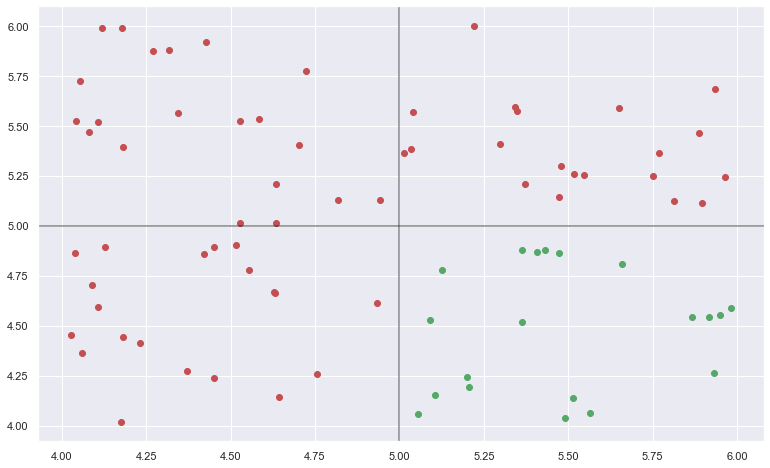

In [3]:
fig, ax = plt.subplots(figsize = (13, 8))

x1 = np.random.random(20) + 5
y1 = np.random.random(20) + 4

x2 = np.random.random(20) + 4
y2 = np.random.random(20) + 4

x3 = np.random.random(20) + 5
y3 = np.random.random(20) + 5

x4 = np.random.random(20) + 4
y4 = np.random.random(20) + 5

ax.scatter(x1, y1, color = 'g')
ax.scatter(x2, y2, color = 'r')
ax.scatter(x3, y3, color = 'r')
ax.scatter(x4, y4, color = 'r')
ax.axvline(5, color = 'k', alpha = 0.5)
ax.axhline(5, color = 'k', alpha = 0.5);

In this case our desicion tree have the following form:

<img src="Árbol de Decisión.png">



As you can see, decision trees usually have sub-trees that serve to fine-tune the prediction of the previous node. This is so until we get to a node that does not split. This last node is known as a leaf node or leaf node. Let’s see a graphic example:


<img src = https://anderfernandez.com/wp-content/uploads/2021/01/image.png.webp>


Seen like this, a decision tree is very simple, but in practice, how do we define these classification rules?

In this notebook we are going to implement our decision tree to find out:

## How to construct a decision tree?

There are 2 popular tree building-algorithm out there: `Classification and Regression Tree (CART)`, and `ID3`. The main difference between these two models is the cost function that they use. The cost function decides which question to ask and how each node being split.

There are 2 cost functions that we will talk about in this post: the **Gini Impurity** and **Entropy**

## Gini Impurity and Gini Index


### Gini Impurity

Gini impurity is the cost function being used in the CART method. Gini Impurity measures how much noise a category has. For starters, each data feature may consist of many categories. For example, the weather feature can have categories: rain, sunny, or snowy; a numerical feature such as grade can be divide into 2 blocks: <70 or ≥70. Gini impurity can be calculated by the following formula:


$$Gini(K) = \sum_{i \in N} P_{i, K} (1 - P_{i, K}) = 1 - \sum_{i \in N} P_{i, k}^{2}$$


Where:

- $N$ is the list of classes (in a binary case $N = \{0, 1\}$)
- $K$ is the category in the feature variable.
- $P_{i, K}$ is the probability of category $K$ having class $i$


The maximum of the Gini impurity is obtained when we are not certain of anything, that is, when $P_{i, K}$ is $1 - \frac{1}{n}$ for each class (where $n$ is the number of classes in $N$). The minimum value is reached when we are certain that the elements of category $k$ are of the same class (in this case some $P_{i, K} = 1$ and the others are $0$ so the Gini index takes the value $0$).

In [4]:
classification   = ['Freshman','Freshman','Sophomore','Junior','Freshman','Sophomore']
hour_of_practice = ['>2h','>2h','>2h','<2h','>2h','<2h']
pass_the_quiz    = ['Yes','Yes','Yes', 'Yes', 'No','No']

In [5]:
data = pd.DataFrame({'Classification':classification, 'hour of practice':hour_of_practice, "Pass the quiz":pass_the_quiz })

In [6]:
data

,Classification,hour of practice,Pass the quiz
0,Freshman,>2h,Yes
1,Freshman,>2h,Yes
2,Sophomore,>2h,Yes
3,Junior,<2h,Yes
4,Freshman,>2h,No
5,Sophomore,<2h,No


From the data, the freshmen and sophomore pass the test if they study more than 2h and fail if they study less. The junior cheats the system and always passes the test.


Let’s compute the Gini Impurity of the `classification` column:

In [8]:
def gini_impurity(k, column, target):
    
    aux = 0 #for the sum of probabilities
    index = column[column == k].index #the index of the elements in the category k
    cat_in_target = target[index] #class of each element of the category k
    
    for c in cat_in_target.unique():
        p = (cat_in_target == c).sum() / len(cat_in_target)
        aux += p ** 2
        
    return 1 - aux

In [9]:
msn = 'Gini({}) = {}'
for k in data['Classification'].unique():
    g = gini_impurity(k, data['Classification'], data['Pass the quiz'])
    print(msn.format(k, g))

Gini(Freshman) = 0.4444444444444444
Gini(Sophomore) = 0.5
Gini(Junior) = 0.0


In [10]:
4 / 9

0.4444444444444444

- $Gini(Freshman) = 1 - (P_{No}^2 + P_{Yes}^2) = 1 - ((\frac{1}{3})^2 + (\frac{2}{3})^2) = \frac{4}{9}$
- $Gini(Sophomore) = 1 - (P_{No}^2 + P_{Yes}^2) = 1 - ((\frac{1}{2})^2 + (\frac{1}{2})^2) = \frac{1}{2}$
- $Gini(Junior) = 1 - (P_{No}^2 + P_{Yes}^2) = 1 - ((0)^2 + (1)^2) = 0$


The Gini values tell us the value of noises present in the data set. In this case, the junior has 0 noise since we know all the junior will pass the test. On the other hand, the sophomore has the maximum noise.

### Gini Index

Gini Index combines the category noises together to get the feature noise. Gini Index is the weighted sum of Gini Impurity based on the corresponding fraction of the category in the feature. The formula is:

$$I_{Gini}(a) = \sum_{i \in M} P_{k, a} Gini(k)$$

- $a$ is the feature, the column.
- $M$ is the list of all categories in feature $a$.
- $P_{k, a}$ is the fraction of category k in feature $a$.

Applying Gini Index to `classification` we obtain:

In [11]:
def gini_index(column, target):
    
    gini = 0
    
    for k in column.unique():
        p = (column == k).sum() / len(column)
        gini += p * gini_impurity(k, column, target)
        
    return gini

In [12]:
gini_index(data['Classification'], data['Pass the quiz'])

0.38888888888888884

In [13]:
7 / 18

0.3888888888888889

- $I_{Gini}(Classification) = P_{Freshman, Classification} Gini(Freshman) + P_{Sophomore, Classification} Gini(Sophomore) + P_{Junior, Classification} Gini(Junior)$
- $I_{Gini}(Classification) = \frac{1}{2} \frac{4}{9} + \frac{1}{3} \frac{1}{2} + \frac{1}{6} 0 = \frac{7}{18}$

Now that we can calculate the `Gini index` we do it for each of our predictor columns and we will ask the first question (split) on the column with the lowest `Gini index`.

In [14]:
msn = 'Gini Index of {:20} = {}'
for c in data.drop('Pass the quiz', axis = 1).columns:
    print(msn.format(c, gini_index(data[c], data['Pass the quiz'])))

Gini Index of Classification       = 0.38888888888888884
Gini Index of hour of practice     = 0.41666666666666663


Since Classification has less noise than the hour of practice, the first split goes for the Classification feature.

## Entropy and Information Gain

### Entropy

We had already talked about the concept of **entropy** before, it spoke to us about the uncertainty we have regarding some event, an event that we are sure of would have a minimum entropy, if we have total uncertainty we would have a maximum entropy.

$$
H(E) =
\left\{
\begin{array}{ll}
- \sum_{i \in N} P(i | E) \log_{2} (P(i | E)) & P(i | E) \ne 0 \text{ for all } i\\
0 & \text{otherwise}\\
\end{array}
\right.
$$

- $N$ is the list of all classes
- $P(i | E)$ is the probability of event $E$ having class $i$

Applying this formula to _freshmen_, _sophomore_, and _junior_ we obtained:

In [7]:
data

,Classification,hour of practice,Pass the quiz
0,Freshman,>2h,Yes
1,Freshman,>2h,Yes
2,Sophomore,>2h,Yes
3,Junior,<2h,Yes
4,Freshman,>2h,No
5,Sophomore,<2h,No


- $H(Freshman) = - (P(\text{Yes} | \text{Freshman}) log_{2}(P(\text{Yes} | \text{Freshman})) + P(\text{No} | \text{Freshman}) log_{2}(P(\text{No} | \text{Freshman}))) = - (\frac{2}{3}log_{2}(\frac{2}{3}) + \frac{1}{3}log_{2}(\frac{1}{3})) = 0.9183$
- $H(Sophomore) = - (\frac{1}{2}log_{2}(\frac{1}{2}) + \frac{1}{2}log_{2}(\frac{1}{2})) = 1$
- Since $P(\text{No} | \text{Junior} = 0$ then $H(Junior) = 0$

In [17]:
def entropy(E, column, target):

    mask = column == E
    
    result = 0
    
    for c in target.unique():
        p = (target[mask] == c).sum() / len(target[mask])
        
        if p != 0:
            result += p * np.log2(p)
        
        else:
            return 0
        
    return -result

In [16]:
msn = 'H({}) = {}'
for k in data['Classification'].unique():
    g = entropy(k, data['Classification'], data['Pass the quiz'])
    print(msn.format(k, g))

H(Freshman) = 0.9182958340544896
H(Sophomore) = 1.0
H(Junior) = 0


Let's compare the **entropy** with the **Gini impurity**

In [18]:
msn = 'Gini({}) = {}'
for k in data['Classification'].unique():
    g = gini_impurity(k, data['Classification'], data['Pass the quiz'])
    print(msn.format(k, g))

Gini(Freshman) = 0.4444444444444444
Gini(Sophomore) = 0.5
Gini(Junior) = 0.0


### Information Gain

After obtaining the entropy for each category, we can combine them to get the information gain values for the features. The more information we gain, the better. The formula is:

$$IG(T, a) = H(T) - \sum_{i \in a} P(i) H(i)$$

Here $H(T)$ is the total entropy, an this is:

$$
H(T) =
\left\{
\begin{array}{ll}
- \sum_{i \in N} P(i) \log_{2} (P(i)) & P(i) \ne 0 \text{ for all } i\\
0 & \text{otherwise}\\
\end{array}
\right.
$$

- $T$ is the sample space
- $a$ is the feature

In [19]:
def total_entropy(target):
    
    result = 0
    
    for c in target.unique():
        p = (target == c).sum() / len(target)
        
        if p != 0:
            result += p * np.log2(p)
        
        else:
            return 0
        
    return -result

In [20]:
total_entropy(data['Pass the quiz'])

0.9182958340544896

In [21]:
def information_gain(column, target):
    
    h_t = total_entropy(target)
    
    aux = 0
    for k in column.unique():
        p = (column == k).sum() / len(column)        
        aux += p * entropy(k, column, target)
        
        
    
        
    return h_t - aux

In [22]:
information_gain(data['Classification'], data['Pass the quiz'])

0.12581458369391152

Now let's calculate which of our columns gives us the greatest information gain, note that $IG$ is a change in entropy, which means that the lower the $IG$, the more information we gain.

In [23]:
msn = 'IG of {:20} = {}'
for c in data.drop('Pass the quiz', axis = 1).columns:
    print(msn.format(c, gini_index(data[c], data['Pass the quiz'])))

IG of Classification       = 0.38888888888888884
IG of hour of practice     = 0.41666666666666663


Thus, _Classification_ has more information and so this will be our first split.

In both methods, Classification is the first pick. The second split is the remaining feature, the hour of study, and we obtain the following tree:


<img src = https://miro.medium.com/max/2400/1*Ss_MwsysjX8tQkigsXFLwg.png>


Note that this tree is extremely biased because the data set has only 6 observations. A decision tree on real data is much bigger and more complicated.

# Criteria to stop the splitting tree


As the data getting more complex, the decision tree also expands. Nonetheless, if we keep the tree growing until all the training data is classified, our model will be overfitting. Therefore, learning when to stop is very important. Let’s take a look at some commonly used criteria:


- The number of observations in the nodes: The ideal upper bound is 5% of the total training dataset.


- The tree’s depth: we can pre-specified the limit of the depth so that the tree won't expand excessively when facing complex datasets.



# And the continuous variables?


Until now it might seem that we have forgotten about continuous numerical variables but we have to work them separately, the idea is to create variables like the ones in the previous example from them.

In [24]:
np.random.seed(1995)

In [25]:
x1 = np.random.random(5) + 5
y1 = np.random.random(5) + 4

x2 = np.random.random(5) + 4
y2 = np.random.random(5) + 4

x3 = np.random.random(5) + 5
y3 = np.random.random(5) + 5

x4 = np.random.random(5) + 4
y4 = np.random.random(5) + 5


x = list(x1) + list(x2) + list(x3) + list(x4)
y = list(y1) + list(y2) + list(y3) + list(y4)
target = ['g'] * 5 + ['r'] * 15
data = pd.DataFrame({'x1' :  x, 'x2' : y, 'y' : target})

In [26]:
data

,x1,x2,y
0,5.348526,4.961205,g
1,5.372211,4.246980,g
2,5.444543,4.695837,g
3,5.579550,4.406196,g
4,5.964057,4.734401,g
5,4.175869,4.688678,r
6,4.411131,4.772541,r
7,4.754680,4.014275,r
8,4.835945,4.974265,r
9,4.190131,4.224454,r


The idea is to order the data with respect to the characteristic with which we want to work and observe how the target variable changes.

In [27]:
data.sort_values('x1')[['x1', 'y']]

,x1,y
15,4.063376,r
17,4.132064,r
5,4.175869,r
9,4.190131,r
6,4.411131,r
16,4.425568,r
7,4.754680,r
8,4.835945,r
18,4.861472,r
19,4.982760,r


In [28]:
candidate1 = 5.348526
candidate2 = 5.387450

In [29]:
aux = data['x1'] < candidate1

In [30]:
aux

0      True
1     False
2     False
3     False
4     False
5      True
6      True
7      True
8      True
9      True
10    False
11     True
12     True
13     True
14    False
15     True
16     True
17     True
18     True
19     True
Name: x1, dtype: bool

In [31]:
gini_index(aux, data['y'])

0.22619047619047622

In [32]:
aux = data['x1'] < candidate2

In [33]:
gini_index(aux, data['y'])

0.25

### Exercise 

- Write a function that finds the best point to split the data

In [34]:
def get_candidates(column, target):
    candidates = []
    
    index = column.sort_values().index
    
    column = column[index]
    target = target[index]
    
    for i in range(1, len(index)):
        
        if target[index[i]] != target[index[i - 1]]:
            candidates.append(column[index[i]])
            
    return candidates

In [35]:
get_candidates(data['x1'], data['y'])

[5.348525866104282,
 5.387449703573384,
 5.444542520228588,
 5.61378345109673,
 5.96405710142795]

In [36]:
def get_split(column, target, verbose = False):
    
    candidates = get_candidates(column, target)
    ginis = []
    
    for c in candidates:
        aux = column < c
        ginis.append(gini_index(aux, target))
    
    if verbose:
        msn = 'candidate:{} → Gini: {}'
        for c, g in zip(candidates, ginis):
            print(msn.format(c, g))
    
    if ginis == []:
        return None
    
    return candidates[np.argmin(ginis)]

In [37]:
get_split(data['x1'], data['y'], verbose = True)

candidate:5.348525866104282 → Gini: 0.14285714285714285
candidate:5.387449703573384 → Gini: 0.2933333333333333
candidate:5.444542520228588 → Gini: 0.25
candidate:5.61378345109673 → Gini: 0.3611111111111111
candidate:5.96405710142795 → Gini: 0.31578947368421045


5.348525866104282

In [38]:
def make_node(data, target):
    
    ginis  = []
    values = []
    
    for c in data.columns:
        value = get_split(data[c], target)
        aux   = data[c] < value
        
        ginis.append(gini_index(aux, target))
        values.append(value)
        
        
    column, value = data.columns[np.argmin(ginis)], values[np.argmin(ginis)]
    
    mask = data[column] < value
    
    left, right = (data[mask], target[mask]), (data[~mask], target[~mask])
    
    return {'column' : column, 'value' : value, 'groups' : (left, right)}

In [39]:
data = [[2.771244718,1.784783929,0],
        [1.728571309,1.169761413,0],
        [3.678319846,2.81281357,0],
        [3.961043357,2.61995032,0],
        [2.999208922,2.209014212,0],
        [7.497545867,3.162953546,1],
        [9.00220326,3.339047188,1],
        [7.444542326,0.476683375,1],
        [10.12493903,3.234550982,1],
        [6.642287351,3.319983761,1]]

data = pd.DataFrame(data, columns = ['x1', 'x2', 'y'])   

In [40]:
data

,x1,x2,y
0,2.771245,1.784784,0
1,1.728571,1.169761,0
2,3.678320,2.812814,0
3,3.961043,2.619950,0
4,2.999209,2.209014,0
5,7.497546,3.162954,1
6,9.002203,3.339047,1
7,7.444542,0.476683,1
8,10.124939,3.234551,1
9,6.642287,3.319984,1


In [41]:
X = data.drop('y', axis = 1)
y = data['y']

In [42]:
make_node(X, y)

{'column': 'x1',
 'value': 6.642287351,
 'groups': ((         x1        x2
   0  2.771245  1.784784
   1  1.728571  1.169761
   2  3.678320  2.812814
   3  3.961043  2.619950
   4  2.999209  2.209014,
   0    0
   1    0
   2    0
   3    0
   4    0
   Name: y, dtype: int64),
  (          x1        x2
   5   7.497546  3.162954
   6   9.002203  3.339047
   7   7.444542  0.476683
   8  10.124939  3.234551
   9   6.642287  3.319984,
   5    1
   6    1
   7    1
   8    1
   9    1
   Name: y, dtype: int64))}

we are going to continue creating nodes until one of the acceptance criteria is met, at that time we will have the leaf nodes that we will use to make the prediction.

In [43]:
l = [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2]

In [45]:
max(l, key = l.count)

1

In [46]:
def terminal_node(target):
    values = target.values.tolist()
    return max(values, key = values.count)

In [47]:
test_data = pd.Series([1, 1, 1, 0])

In [48]:
terminal_node(test_data)

1

In [49]:
def split(node, max_depth, min_size, depth):
    
    left, right = node['groups']
    del(node['groups'])
    
    # check for a no split
    if len(left[0]) == 0:
        node['right'] = terminal_node(right[1])
        return
    
    if len(right[0]) == 0:
        node['left'] = terminal_node(left[1])
        return
    
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = terminal_node(left[1]), terminal_node(right[1])
        return
    
    # process left child
    if len(left[0]) <= min_size:
        node['left'] = terminal_node(left[1])
    else:
        node['left'] = make_node(*left)
        #Agh, the recursion
        split(node['left'], max_depth, min_size, depth + 1)
    
    # process right child
    if len(right) <= min_size:
        node['right'] = terminal_node(right[1])
    else:
        node['right'] = make_node(*right)
        #Agh, the recursion
        split(node['right'], max_depth, min_size, depth + 1)

## Building a Tree

We can now put all of the pieces together.

In [50]:
def tree(data, target, max_depth, min_size):
    
    root = make_node(data, target)
    split(root, max_depth, min_size, 1)
    
    return root

In [51]:
tree(X, y, 1, 1)

{'column': 'x1', 'value': 6.642287351, 'left': 0, 'right': 1}

In [52]:
x1 = np.random.random(5) + 5
y1 = np.random.random(5) + 4

x2 = np.random.random(5) + 4
y2 = np.random.random(5) + 4

x3 = np.random.random(5) + 5
y3 = np.random.random(5) + 5

x4 = np.random.random(5) + 4
y4 = np.random.random(5) + 5


x = list(x1) + list(x2) + list(x3) + list(x4)
y = list(y1) + list(y2) + list(y3) + list(y4)
target = ['g'] * 5 + ['r'] * 15
data = pd.DataFrame({'x1' :  x, 'x2' : y, 'y' : target})

In [53]:
data

,x1,x2,y
0,5.128988,4.946671,g
1,5.556652,4.375871,g
2,5.883638,4.944007,g
3,5.472253,4.461605,g
4,5.928756,4.190926,g
5,4.494225,4.560661,r
6,4.064641,4.010585,r
7,4.294933,4.570327,r
8,4.384309,4.418749,r
9,4.585206,4.386350,r


In [54]:
X = data.drop('y', axis = 1)
y = data['y']

In [55]:
tree1 = tree(X, y, 1, 1)

In [56]:
tree1

{'column': 'x1', 'value': 5.128988376262237, 'left': 'r', 'right': 'g'}

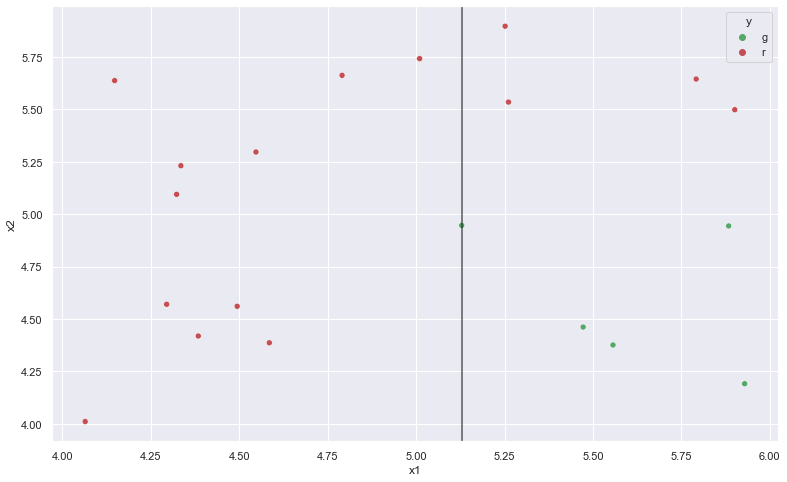

In [57]:
fig, ax = plt.subplots(figsize = (13, 8))

sns.scatterplot(data = data, x = 'x1', y = 'x2', hue = 'y', ax = ax, palette = ['g', 'r'])
ax.axvline(tree1['value'], color = 'k', alpha = 0.7);

In [58]:
tree2 = tree(X, y, 2, 1)

In [59]:
tree2

{'column': 'x1',
 'value': 5.128988376262237,
 'left': {'column': 'x1', 'value': None, 'right': 'r'},
 'right': {'column': 'x2',
  'value': 5.4987624524999665,
  'left': 'g',
  'right': 'r'}}

In [60]:
tree2['left']

{'column': 'x1', 'value': None, 'right': 'r'}

In [61]:
tree2['right']

{'column': 'x2', 'value': 5.4987624524999665, 'left': 'g', 'right': 'r'}

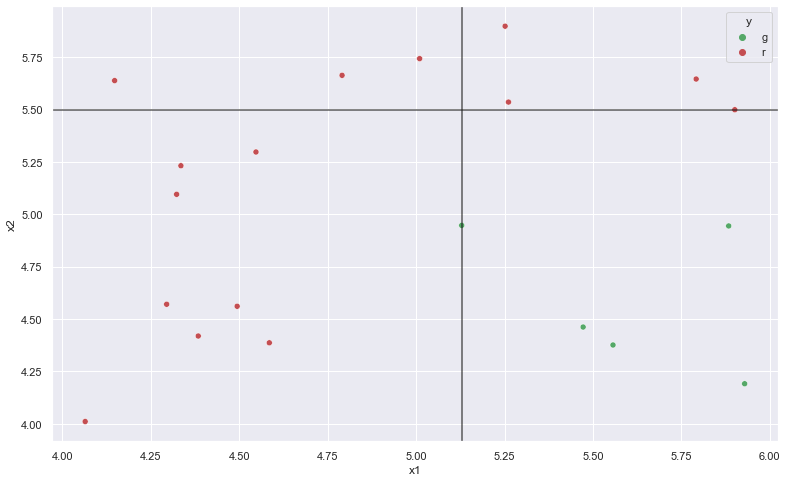

In [62]:
fig, ax = plt.subplots(figsize = (13, 8))

sns.scatterplot(data = data, x = 'x1', y = 'x2', hue = 'y', ax = ax, palette = ['g', 'r'])
ax.axvline(tree2['value'], color = 'k', alpha = 0.7)
ax.axhline(tree2['right']['value'], color = 'k', alpha = 0.7);

## Make a Prediction

Making predictions with a decision tree involves navigating the tree with the specifically provided row of data.

Again, we can implement this using a recursive function, where the same prediction routine is called again with the left or the right child nodes, depending on how the split affects the provided data.

In [63]:
def predict_one(node, row):
    
    
    if node['value'] == None:
        return node['right']
    
    if row[node['column']] < node['value']: #in the left
        
        if isinstance(node['left'], dict):
            return predict_one(node['left'], row)
        
        else:
            return node['left']
    
    else:
        
        if isinstance(node['right'], dict):
            return predict_one(node['right'], row)
        
        else:
            return node['right']

In [65]:
def predict(node, data):
    
    predictions = []
    
    for i in data.index:
        predictions.append(predict_one(node, data.loc[i, :]))
    
    return pd.Series(predictions, index = data.index)

In [66]:
points = [[5.25, 5],
        [5.75, 4.5],
        [4.5, 5.5],
        [4.5, 4.5]]

In [67]:
points = pd.DataFrame(points, columns = ['x1', 'x2'])

In [68]:
points

,x1,x2
0,5.25,5.0
1,5.75,4.5
2,4.50,5.5
3,4.50,4.5


In [69]:
points.loc[0, :]

x1    5.25
x2    5.00
Name: 0, dtype: float64

In [70]:
predict_one(tree1, points.loc[0, :])

'g'

In [71]:
predict(tree1, points)

0    g
1    g
2    r
3    r
dtype: object

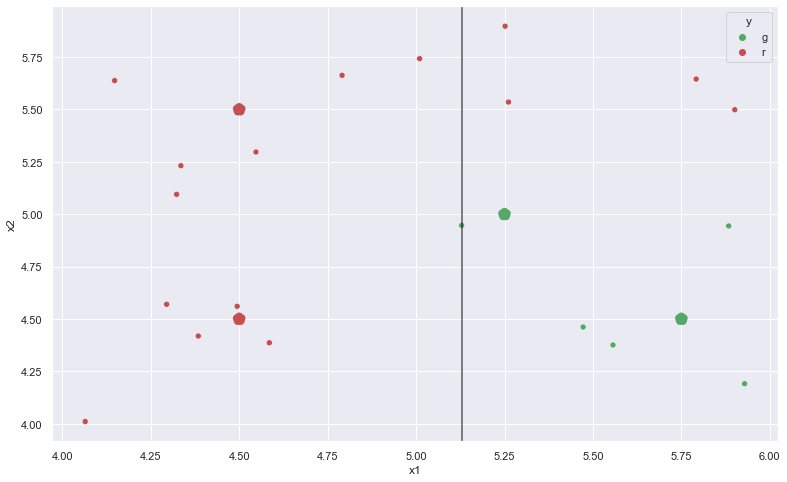

In [72]:
fig, ax = plt.subplots(figsize = (13, 8))

sns.scatterplot(data = data, x = 'x1', y = 'x2', hue = 'y', ax = ax, palette = ['g', 'r'])
ax.axvline(tree1['value'], color = 'k', alpha = 0.7)
ax.scatter(points['x1'], points['x2'], color = predict(tree1, points), marker = 'p', linewidths = 7);

In [73]:
predict_one(tree2, points.loc[1, :])

'g'

In [74]:
predict(tree2, points)

0    g
1    g
2    r
3    r
dtype: object

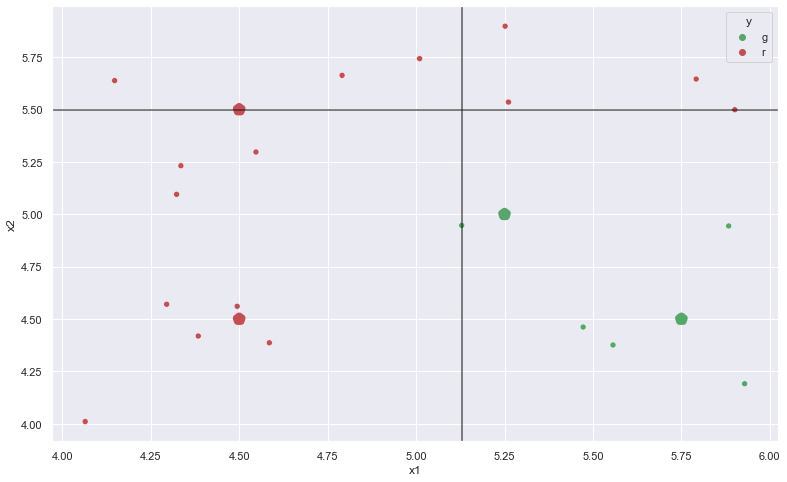

In [75]:
fig, ax = plt.subplots(figsize = (13, 8))

sns.scatterplot(data = data, x = 'x1', y = 'x2', hue = 'y', ax = ax, palette = ['g', 'r'])
ax.axvline(tree2['value'], color = 'k', alpha = 0.7)
ax.axhline(tree2['right']['value'], color = 'k', alpha = 0.7)
ax.scatter(points['x1'], points['x2'], color = predict(tree2, points), marker = 'p', linewidths = 7);

In [76]:
iris = pd.read_csv('Iris.csv')

In [77]:
iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [78]:
iris.drop('Id', axis = 1, inplace = True)

In [79]:
X = iris.drop('Species', axis = 1)
y = iris['Species']

In [80]:
X.shape

(150, 4)

In [85]:
iris_tree = tree(X, y, max_depth = 4, min_size = 5)

In [86]:
iris_tree

{'column': 'PetalLengthCm',
 'value': 3.0,
 'left': {'column': 'SepalLengthCm', 'value': None, 'right': 'Iris-setosa'},
 'right': 'Iris-versicolor'}

In [87]:
y_pred = predict(iris_tree, X)

In [88]:
(y_pred == y).mean()

0.6666666666666666